In [178]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#metric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error



#model
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

date : all data are aggregated by date

shown : số lượng quảng cáo được hiển thị vào một ngày nhất định trên toàn bộ web. Các ấn tượng là miễn phí. Nghĩa là, các công ty chỉ trả tiền nếu người dùng nhấp vào quảng cáo, không phải để hiển thị

clicked : số lần nhấp vào quảng cáo. Đây là những gì các công ty phải trả cho. Bằng cách nhấp vào quảng cáo, người dùng được đưa đến trang web.

converted : số lượng chuyển đổi trên trang web đến từ quảng cáo. Để được tính, một chuyển đổi phải xảy ra cùng ngày với lần nhấp vào quảng cáo.

avg_cost_per_click :trung bình, chi phí cho mỗi nhấp chuột đó.

total_revenue : doanh thu đến từ các chuyển đổi là bao nhiêu

ad : chúng tôi có một số nhóm quảng cáo khác nhau. Điều này cho biết nhóm quảng cáo nào chúng tôi đang xem xét

In [180]:
#Dữ liệu tháng 10 và 11
data = pd.read_csv('ad_table.csv',parse_dates=['date'])
data.head(5)

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 7 columns):
date                  2115 non-null datetime64[ns]
shown                 2115 non-null int64
clicked               2115 non-null int64
converted             2115 non-null int64
avg_cost_per_click    2115 non-null float64
total_revenue         2115 non-null float64
ad                    2115 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 115.8+ KB


In [182]:
data.describe()

,shown,clicked,converted,avg_cost_per_click,total_revenue
count,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000
mean,68299.844444,3056.077069,126.453901,1.373749,1966.517589
std,48884.821409,3783.579969,233.420826,0.754331,3942.018757
min,0.000000,0.000000,0.000000,0.000000,-200.150000
25%,28030.500000,744.000000,18.000000,0.760000,235.470000
50%,54029.000000,1392.000000,41.000000,1.400000,553.300000
75%,97314.500000,3366.500000,103.000000,1.920000,1611.495000
max,192507.000000,20848.000000,1578.000000,4.190000,39623.710000


In [183]:
data['profit'] = data['total_revenue'] - (data['avg_cost_per_click']*data['clicked'])
data['profit_per_shown'] = data['profit'] /  data['shown']


data.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,profit,profit_per_shown
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,-1463.48,-0.022215
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,-1591.75,-0.024451
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,-1018.28,-0.014411
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,-1953.94,-0.027990
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,-1816.55,-0.026641


# Top 5 nhóm ad mang lại profit lớn nhất 

In [184]:
ad_groups_with_profit = data[['ad', 'profit', 'profit_per_shown', 'converted', 'clicked']].groupby('ad').sum().reset_index()
ad_groups_with_profit = ad_groups_with_profit.sort_values(by='profit', ascending=False)

#Tìm các nhóm có profit dương
ad_groups_with_profit_positive = ad_groups_with_profit[ad_groups_with_profit['profit'] > 0]

#Tìm các nhóm có profit âm
ad_groups_with_profit_negative = ad_groups_with_profit[ad_groups_with_profit['profit'] < 0]
#
ad_groups_with_profit_positive

,ad,profit,profit_per_shown,converted,clicked
11,ad_group_2,54456.44,1.072065,6249,61912
24,ad_group_31,40265.93,0.308827,3132,36033
7,ad_group_16,32179.55,1.046841,3702,41764
5,ad_group_14,7252.95,0.862802,1090,13167
19,ad_group_27,2528.73,0.038567,884,28656


# For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).

# # Choose ad_group_2

In [185]:
ad_group_2 = data.loc[data['ad']=='ad_group_2',['date','shown']]
ad_group_2.set_index('date', inplace=True)
ad_group_2.columns = ["y"]
ad_group_2.head()

,y
date,
2015-10-01,50988
2015-10-02,51934
2015-10-03,53386
2015-10-04,52008
2015-10-05,48766


<h2> Time Series Analysis in Python</h2>
<h3> exponential_smoothing</h3>

Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for **[exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)** that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [186]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

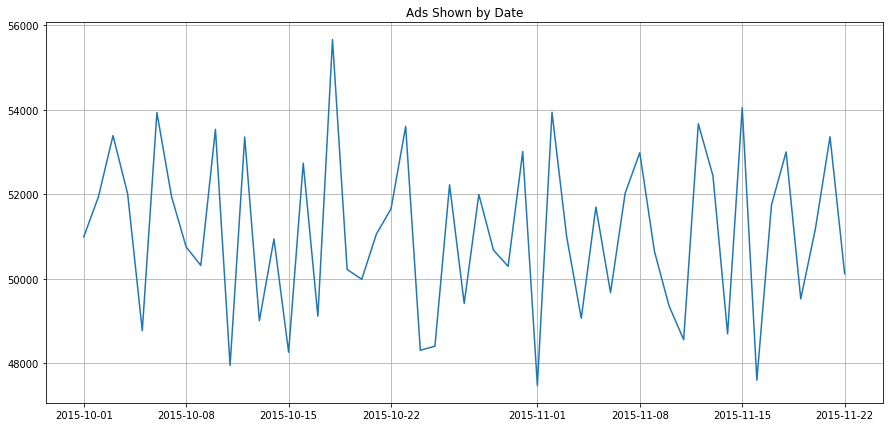

In [187]:
plt.figure(figsize=(15, 7))
plt.plot(ad_group_2.y)
plt.title('Ads Shown by Date')
plt.grid(True)
plt.show()

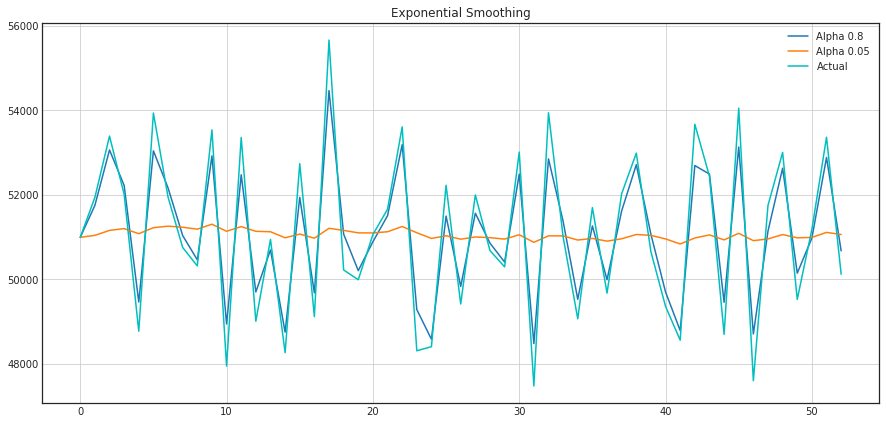

In [188]:
plotExponentialSmoothing(ad_group_2.y, [0.8, 0.05])

## Time series cross validation
<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

<h3>. Định nghĩa metrics loss </h3>

In [189]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [190]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

<h3>. Prepare X_train, X_test, y_train, y_test by Lags of time series </h3>

In [191]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    ad_group_2["lag_{}".format(i)] = ad_group_2.y.shift(i)
    


In [192]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [193]:
y = ad_group_2.dropna().y
X = ad_group_2.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [218]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);


def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

<h2>. Model_1: LinearRegression</h2>

In [219]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

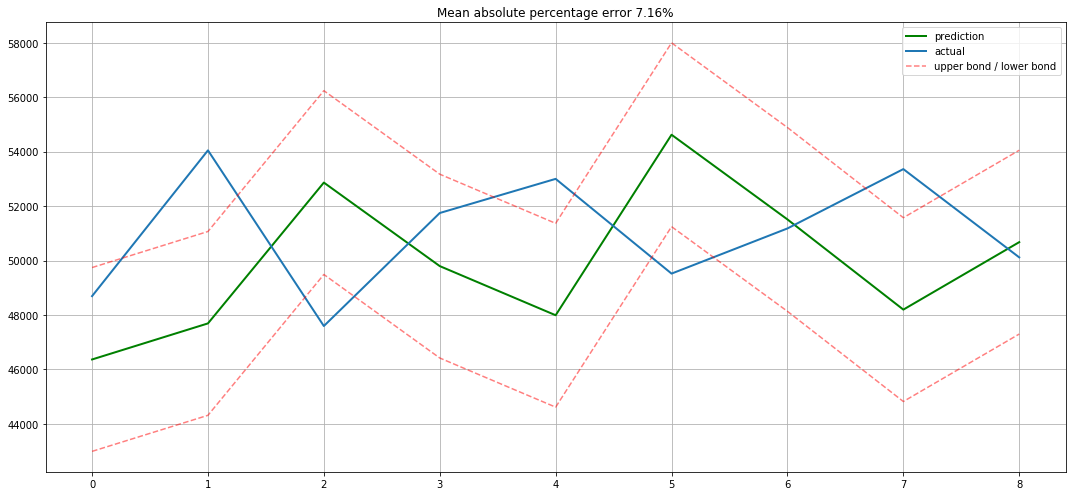

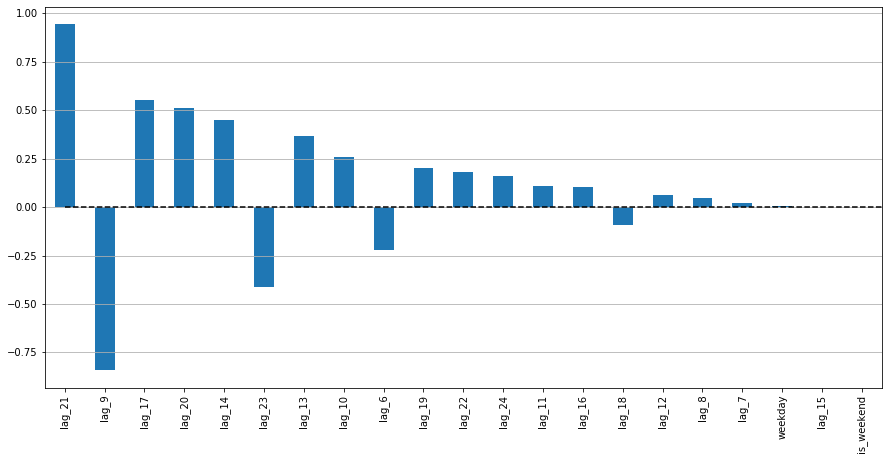

In [220]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [197]:
ad_group_2.index = pd.to_datetime(ad_group_2.index)

#ad_group_2["hour"] = ad_group_2.index.hour # --> unused
ad_group_2["weekday"] = ad_group_2.index.weekday
ad_group_2['is_weekend'] = ad_group_2.weekday.isin([5,6])*1
ad_group_2

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2015-10-01,50988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0
2015-10-02,51934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
2015-10-03,53386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1
2015-10-04,52008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,1
2015-10-05,48766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2015-10-06,53933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2015-10-07,51941,50988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0
2015-10-08,50748,51934.0,50988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0
2015-10-09,50312,53386.0,51934.0,50988.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0


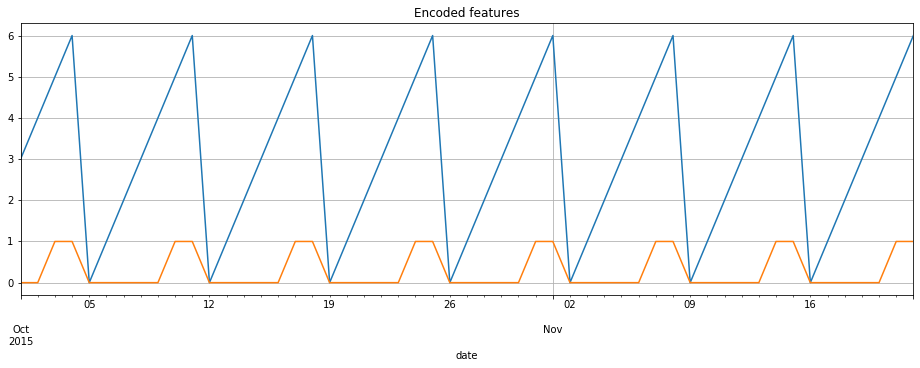

In [198]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
#ad_group_2.hour.plot()
ad_group_2.weekday.plot()
ad_group_2.is_weekend.plot()
plt.grid(True);

In [199]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

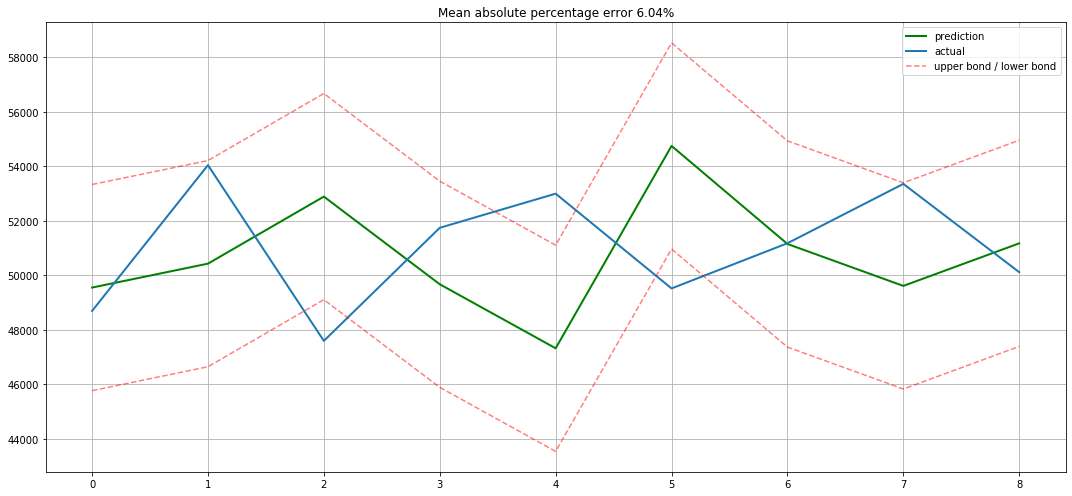

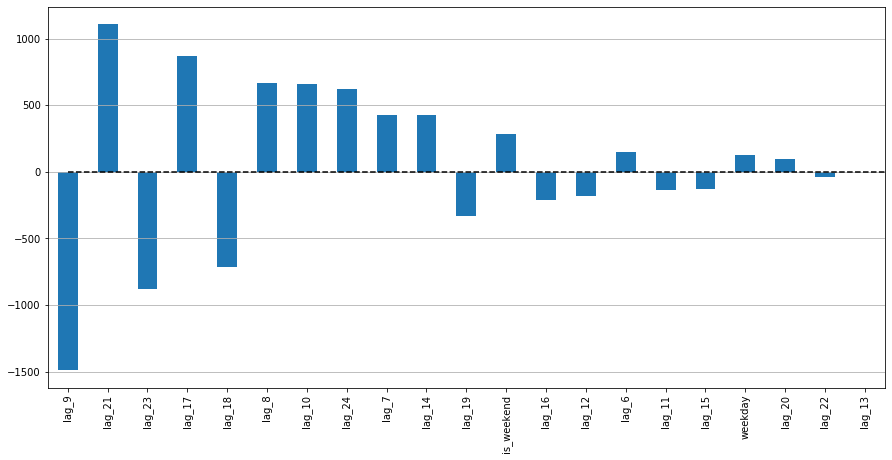

In [200]:
y = ad_group_2.dropna().y
X = ad_group_2.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

<h2>. Model_2: XGBRegressor</h2>

In [201]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

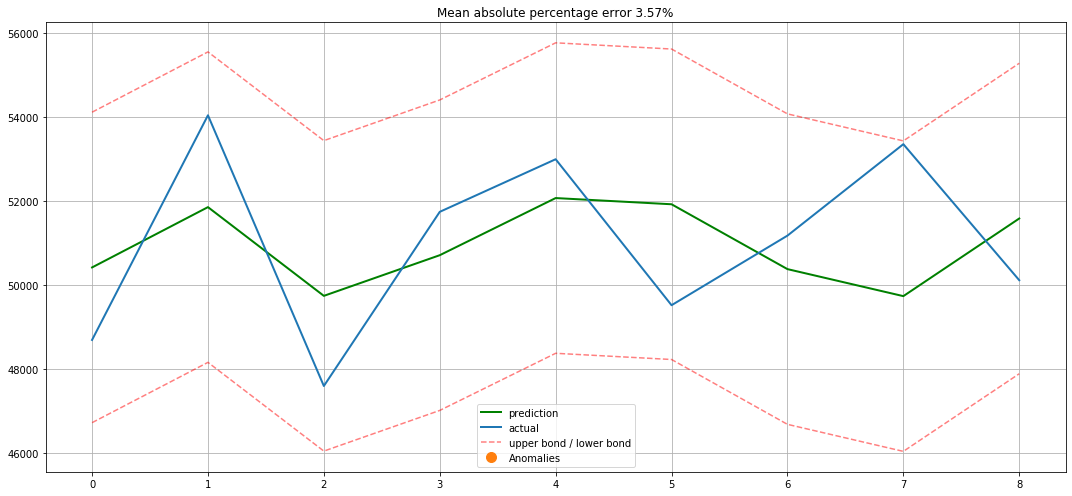

In [202]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

<h2> Model_3: LGBMRegressor </h2>

In [203]:
lgb = LGBMRegressor()#(n_estimators=1000, learning_rate=0.001)
lgb.fit(X_train_scaled, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

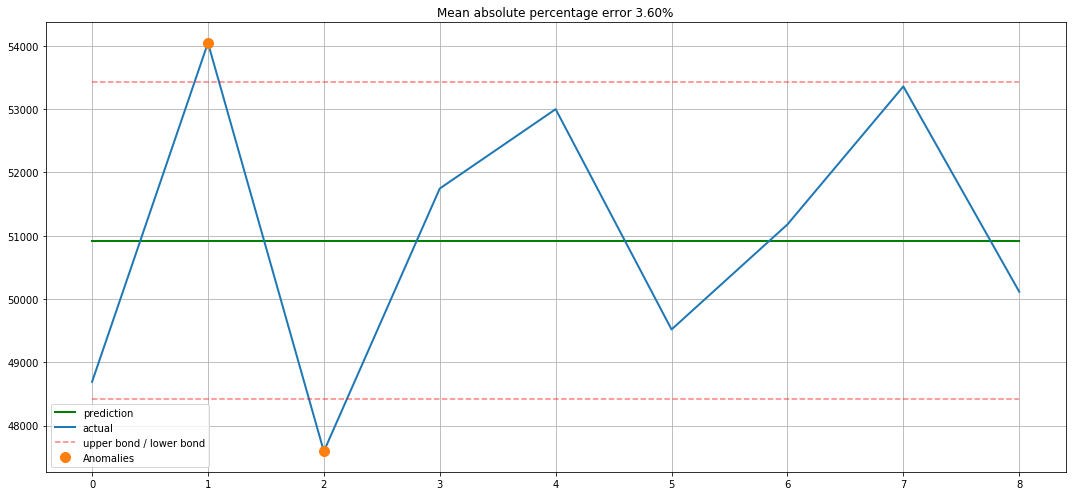

In [204]:
plotModelResults(lgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

<h3>Model_4: RandomForestRegressor </h3>

In [205]:
rdf = RandomForestRegressor()#(n_estimators=1000, n_jobs=-1, random_state=0)
rdf.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

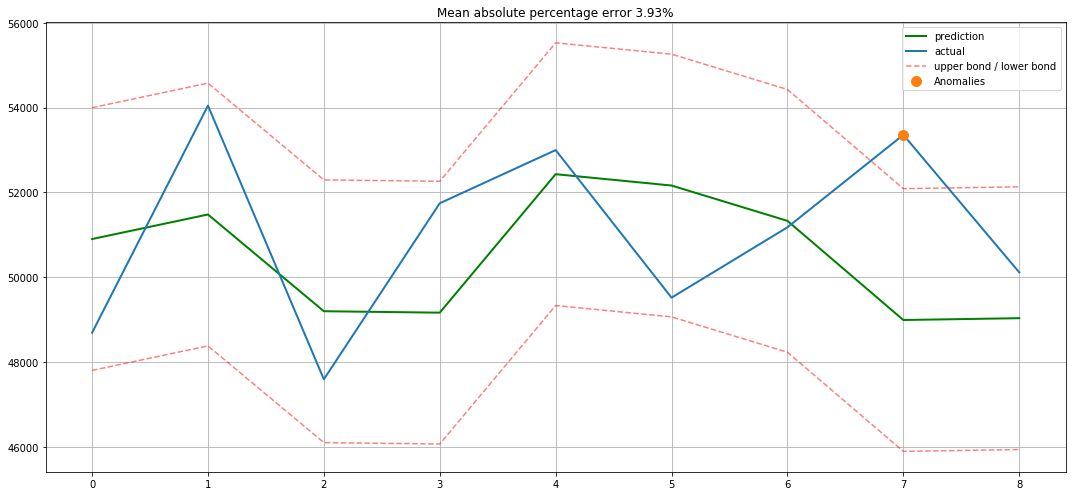

In [206]:
plotModelResults(rdf, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

In [207]:
def create_data_predict(date_as_str):
    dict_val = {'date': date_as_str, 'y': [0]}
    data_predict = pd.DataFrame.from_dict(dict_val)
    data_predict.set_index('date', inplace=True)
    #
    data_predict.index = pd.to_datetime(data_predict.index)
    for i in range(6, 25):
        data_predict["lag_{}".format(i)] = 0
    
    data_predict["weekday"] = data_predict.index.weekday
    data_predict['is_weekend'] = data_predict.weekday.isin([5,6])*1
    
    #drop y
    data_predict = data_predict.dropna().drop(['y'], axis=1)
    
    return data_predict

In [208]:
create_data_predict('2015-12-15')

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2015-12-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [212]:
def active_predict(model, date_as_str):
    data_predict = create_data_predict(date_as_str)
    
    #active scale
    data_predict_scaled = scaler.transform(data_predict)
    
    prediction = model.predict(data_predict_scaled)
    #print('active_predict at {}: {}'.format(date_as_str, prediction[0]))
    return prediction[0]

In [214]:
prediction_lr = active_predict(lr, '2015-12-15')
prediction_xgb = active_predict(xgb, '2015-12-15')
prediction_lgb = active_predict(lgb, '2015-12-15')
prediction_rdf = active_predict(rdf, '2015-12-15')

#
print('prediction_lr at 2015-12-15: {}'.format(prediction_lr))
print('prediction_xgb at 2015-12-15: {}'.format(prediction_xgb))
print('prediction_lgb at 2015-12-15: {}'.format(prediction_lgb))
print('prediction_rdf at 2015-12-15: {}'.format(prediction_rdf))

prediction_lr at 2015-12-15: 26368.540598220065
prediction_xgb at 2015-12-15: 48387.31640625
prediction_lgb at 2015-12-15: 50923.8
prediction_rdf at 2015-12-15: 51793.9
